# Analyzing My Spotify Listening History

**SE_42: Data Science Basics** 

**Justin Brandt - 22.01.003**

---

## Table of Contents


1. [Introduction](#introduction)
1. [Understanding the Data](#understanding-the-data)
1. [Data Preparation](#data-preparation)
1. [Exploratory Data Analysis](#exploratory-data-analysis)
1. [Summary and Insights](#summary-and-insights)
1. [Conclusion](#conclusion)
1. [References and Resources](#references-and-resources)

## Introduction

This project analyzes my Spotify listening history to uncover patterns in music preferences and listening habits.

Some questions I would like to explore are:
- How accurate is my Spotify wrapped data and what can I expect for this year (2024)?
- What kind of patterns exist in my listening habits? 
- Are there any seasonal trends or significant changes in my listening behavior?

## Understanding the Data

The data was obtained by requesting my extended streaming history from Spotify, which covers the years **2019 to 2024**. The dataset consists of JSON files for each year, containing detailed records of every track I played on Spotify, since the creation of my account.

The data is in good quality overall, with minimal missing values, primarily in non critical fields like `episode_name`. Spotify's data attributes<sup>[1]</sup>, are also well structured. For wrapped data used in later sections, I manually made it from the playlists I had for the available years.

## Data Preparation

The dataset was generally clean, requiring minimal processing. Non-informative fields were removed, missing values in critical columns were also removed, and data types were standardized.

### Import Libraries

In [1]:
import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

### Load data

In [2]:
# Read and concatenate JSON files
path_to_files = './my_data/'
all_files = glob.glob(os.path.join(path_to_files, '*.json'))

dataframes = []
for file in all_files:
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        df_temp = pd.DataFrame(data)
        dataframes.append(df_temp)

df = pd.concat(dataframes, ignore_index=True)

### Data Cleaning and Transformation

In [3]:
# Drop columns that are not needed, as well as values where song name is missing
df.drop(['username', 'ip_addr_decrypted', 'platform', 'user_agent_decrypted', 'master_metadata_album_album_name', 'episode_name', 'episode_show_name', 'spotify_track_uri', 'offline', 'spotify_episode_uri', 'offline_timestamp', 'incognito_mode'], axis=1, inplace=True)
df = df.dropna(subset=['master_metadata_track_name'])

In [4]:
# Convert ts to datetime object
df['ts'] = pd.to_datetime(df['ts'])

In [5]:
# Add date components to the dataframe
df['date'] = df['ts'].dt.date
df['year'] = df['ts'].dt.year
df['month'] = df['ts'].dt.month
df['day'] = df['ts'].dt.day
df['hour'] = df['ts'].dt.hour
df['day_of_week'] = df['ts'].dt.day_name()

In [6]:
# Calculate minutes and hours played
df['minutes_played'] = (df['ms_played'] / 60000).round(2)
df['hours_played'] = (df['ms_played'] / 3600000).round(2)

In [7]:
# Sort the dataframe by timestamp and rename all columns
df.sort_values(by='ts', ascending=True, inplace=True)
df.columns = ['Timestamp', 'Milliseconds Played', 'Country', 'Song Name', 'Artist', 'Start Reason', 'End Reason', 'Shuffle', 'Skipped', 'Date', 'Year', 'Month', 'Day', 'Hour', 'Day of Week', 'Minutes Played', 'Hours Played']

In [8]:
# Change country codes to country names
def map_country_codes(code):
    country_mapping = {
        'NA': 'Namibia',
        'DE': 'Germany',
        'US': 'United States',
        'IT': 'Italy',
        'ZZ': 'South Africa', #ZZ is an unknown code so I am mapping it to South Africa, as that is the only logical choice given countries I have been to
        'ES': 'Spain',
        'CA': 'Canada',
        'FR': 'France',
        'CH': 'Switzerland',
        'GB': 'United Kingdom',
        'LU': 'Luxembourg',
        'SE': 'Sweden',
    }
    
    return country_mapping.get(code, code)

df['Country'] = df['Country'].apply(map_country_codes)


## Exploratory Data Analysis

### Descriptive Stats for Minutes Played

In [9]:
print("Shape of the dataframe:", df.shape)
print("Date Range:", df['Timestamp'].min(), "to", df['Timestamp'].max())
print("\nStatistics for 'Minutes Played':")
print(df['Minutes Played'].describe().round(2))

Shape of the dataframe: (101628, 17)
Date Range: 2019-03-10 09:30:04+00:00 to 2024-10-22 21:48:39+00:00

Statistics for 'Minutes Played':
count    101628.00
mean          2.06
std           2.02
min           0.00
25%           0.04
50%           2.03
75%           3.56
max          18.31
Name: Minutes Played, dtype: float64


### Visual Analyses of Dataset

#### Listening Time

##### Total Listening Time

2020 had the highest listening time (~1000 hours), while 2024 showed a steep decline (~200 hours).

Full years (2020-2023),  where data is available from January 1st to December 31st, averaged about 697 hrs of listening per year with a standard deviation of 181. 2019 and 2024 are not full years as they have missing months.

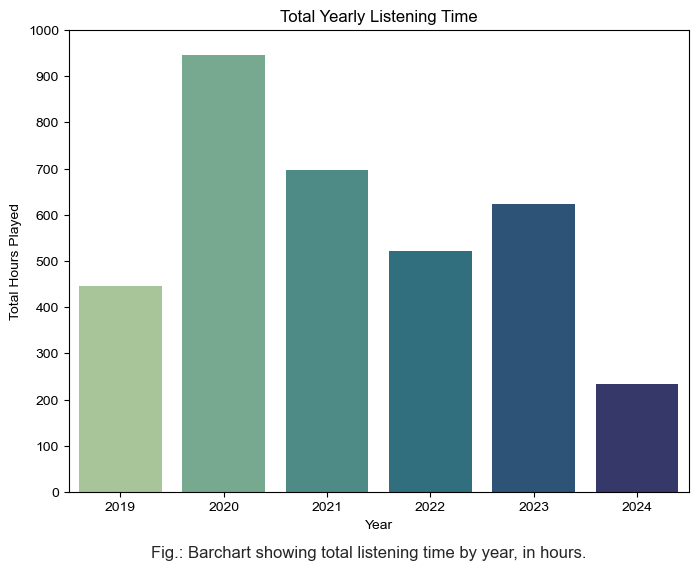

In [10]:
yearly_listening = df.groupby('Year')['Hours Played'].sum().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(data=yearly_listening, x='Year', y='Hours Played', palette='crest', hue='Year', legend=False)
sns.set_style("whitegrid")

plt.yticks(np.arange(0, yearly_listening['Hours Played'].max() + 100, 100))

plt.title('Total Yearly Listening Time')
plt.xlabel('Year')
plt.ylabel('Total Hours Played')
plt.figtext(0.5, 0, "Fig.: Barchart showing total listening time by year, in hours.", ha="center", fontsize=12, wrap=True)

plt.show()

In [11]:
# Average listening of full years
full_years_listening = df[df['Year'].isin([2020, 2021, 2022, 2023])]
full_years_listening_hours = full_years_listening.groupby('Year')['Hours Played'].sum().reset_index()

fy_avg_listening = full_years_listening_hours['Hours Played'].mean()
print("\nAverage Listening Time per Year for Full Years:", fy_avg_listening.round(2) , "hours")


Average Listening Time per Year for Full Years: 696.71 hours


In [12]:
# Standard deviation
fy_std_listening = full_years_listening_hours['Hours Played'].std()
print("\nStandard Deviation of Listening Time per Year:", fy_std_listening)


Standard Deviation of Listening Time per Year: 181.32591860606507


##### Monthly Listening Patterns

Monthly listening patterns show occasional spikes, typically aligned with significant life events rather than seasonal trends, as opposed to any seasonal trends. For 2024, only February managed to cross above 40 hours, while all other months there is data for, barely or have not even crossed 20 hours.

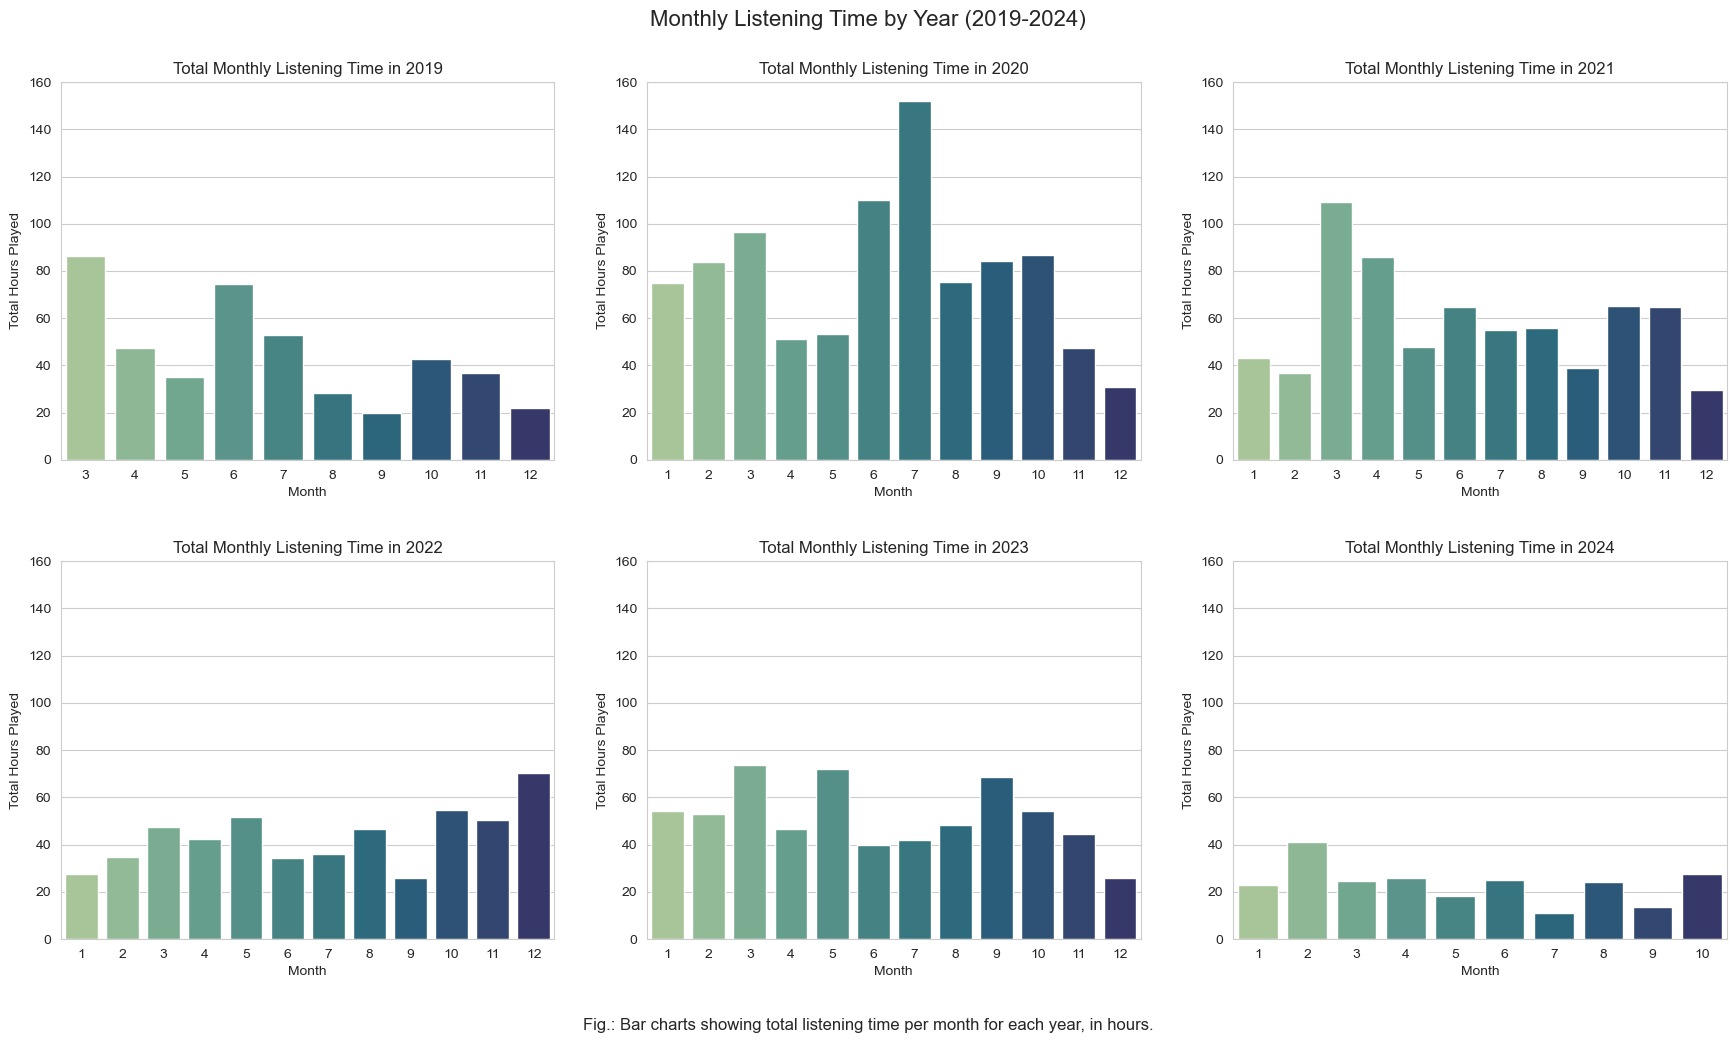

In [13]:
years = range(2019, 2025) 

max_hours = df[df['Year'].isin(years)].groupby(['Year', 'Month'])['Hours Played'].sum().max()
max_hours_rounded = np.ceil(max_hours / 20) * 20

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Create a 2x3 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, year in enumerate(years):
    # Filter data for the current year
    df_year = df[df['Year'] == year]
    monthly_listening = df_year.groupby('Month')['Hours Played'].sum().reset_index()
    monthly_listening = monthly_listening.sort_values('Month')

    # Plot for the current year on the respective subplot
    sns.barplot(data=monthly_listening, x='Month', y='Hours Played', palette='crest', ax=axes[i], hue='Month', legend=False)
    
    # Set y-axis limit for consistency with max value being the next multiple of 20 from the max_hours
    axes[i].set_ylim(0, max_hours_rounded)
    
    # Set titles and labels for each subplot
    axes[i].set_title(f'Total Monthly Listening Time in {year}')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Total Hours Played')

# Adjust layout and add a common figure title
fig.tight_layout(pad=3.0)
fig.suptitle("Monthly Listening Time by Year (2019-2024)", fontsize=16, y=1.01)
plt.figtext(0.5, -0.01, "Fig.: Bar charts showing total listening time per month for each year, in hours.", 
            ha="center", fontsize=12, wrap=True)

plt.show()

##### Overall Listening Activity

Listening activity peaks between midnight and 7 AM, with Sunday showing the most consistent daytime activity.

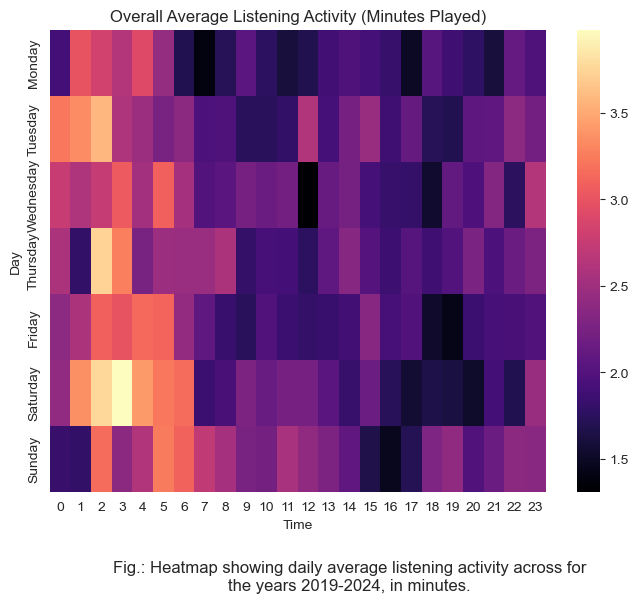

In [14]:
heatmap_data = df.pivot_table(index='Day of Week', columns='Hour', values='Minutes Played', aggfunc='mean')
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days_order)

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, cmap='magma')

plt.title('Overall Average Listening Activity (Minutes Played)')
plt.xlabel('Time')
plt.ylabel('Day')
plt.figtext(0.5, -0.05, "Fig.: Heatmap showing daily average listening activity across for\nthe years 2019-2024, in minutes.", ha="center", fontsize=12, wrap=True)

plt.show()

##### Annual Listening Activity Heatmaps

Listening activity declined significantly after 2020, with reduced engagement during late-night hours in 2022 and beyond.

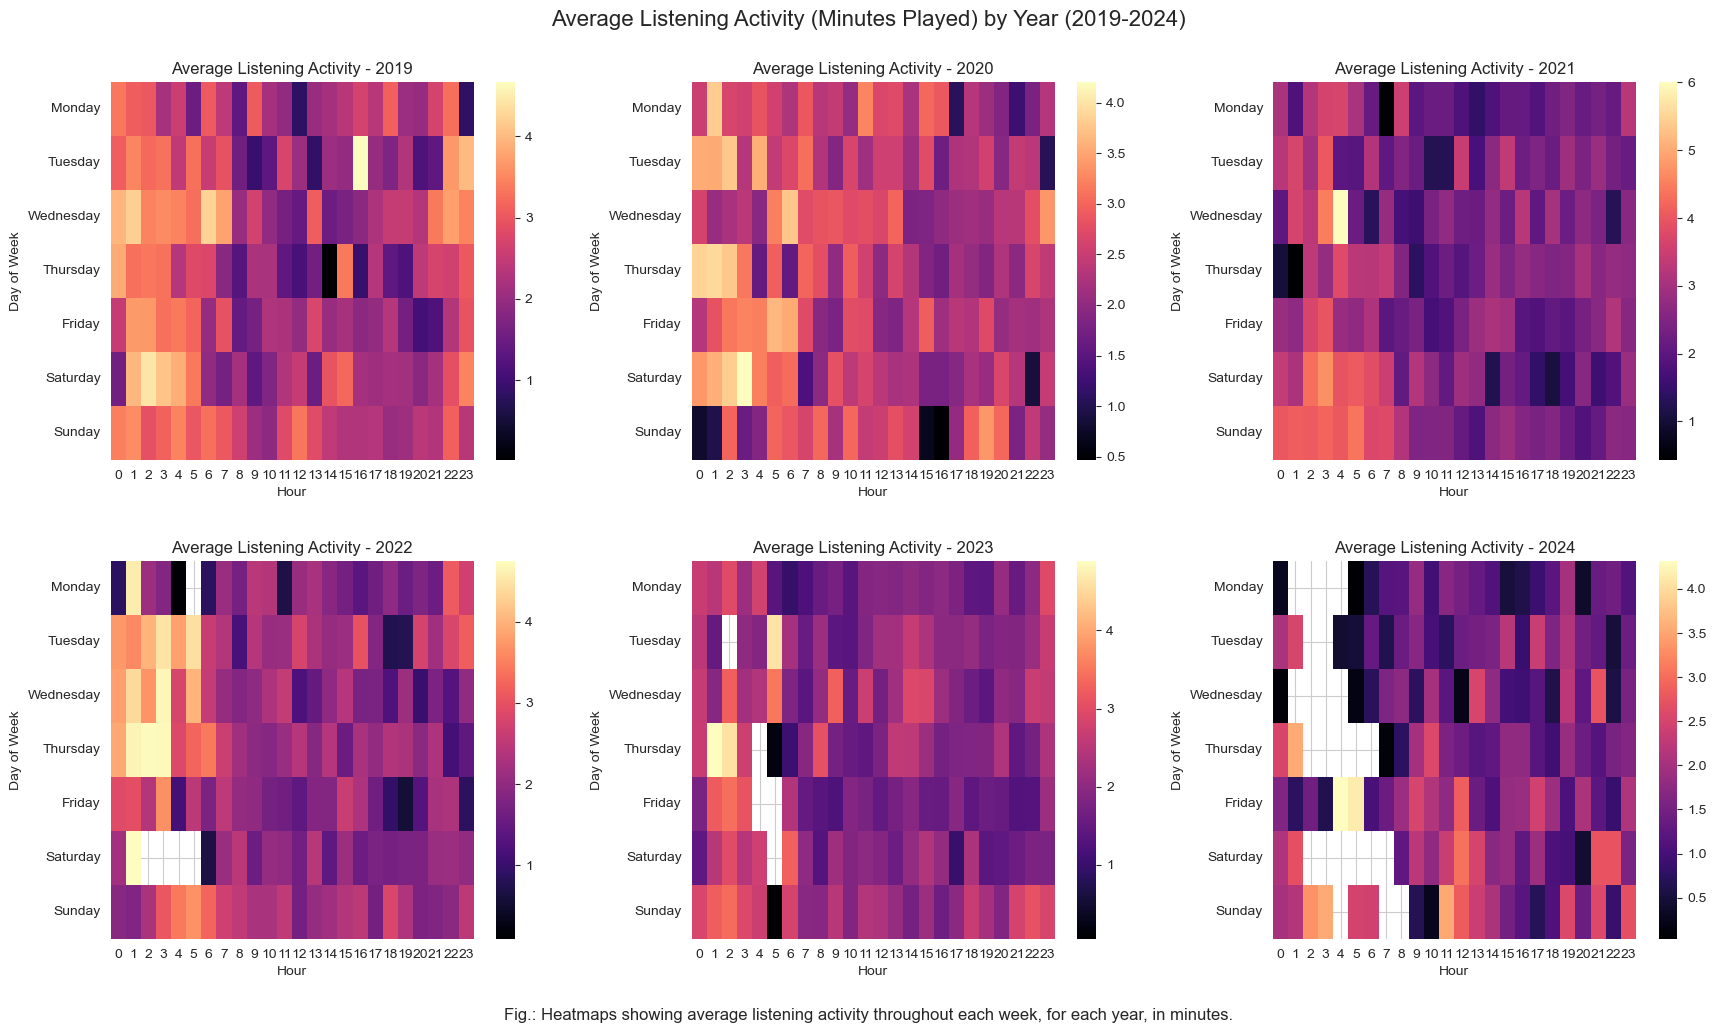

In [15]:
years = range(2019, 2025)

def get_heatmap_data_for_year(df, year):
    yearly_data = df[df['Year'] == year]
    heatmap_data = yearly_data.pivot_table(index='Day of Week', columns='Hour', values='Minutes Played', aggfunc='mean')
    
    # Order days from Monday to Sunday
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    heatmap_data = heatmap_data.reindex(days_order)
    
    return heatmap_data

# Set up a grid of subplots for each year
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, year in enumerate(years):
    # Generate heatmap data for the current year
    heatmap_data = get_heatmap_data_for_year(df, year)
    
    # Plot heatmap on the current axis
    sns.heatmap(heatmap_data, cmap='magma', cbar=True, ax=axes[i])
    
    # Set title and labels for each subplot
    axes[i].set_title(f'Average Listening Activity - {year}')
    axes[i].set_xlabel('Hour')
    axes[i].set_ylabel('Day of Week')
    axes[i].set_xticks([x + 0.5 for x in range(24)])
    axes[i].set_xticklabels(range(24))

# Adjust layout and add a common title for the figure
fig.tight_layout(pad=3.0)
fig.suptitle("Average Listening Activity (Minutes Played) by Year (2019-2024)", fontsize=16, y=1.01)
plt.figtext(0.5, 0, "Fig.: Heatmaps showing average listening activity throughout each week, for each year, in minutes.", 
            ha="center", fontsize=12, wrap=True)

plt.show()

In [16]:
# Average listening time on weekdays vs on weekends

df['Is Weekend'] = df['Day of Week'].isin(['Saturday', 'Sunday'])
weekend_listening = df.groupby('Is Weekend')['Minutes Played'].mean()
weekday_listening = df.groupby(df['Is Weekend']== False)['Minutes Played'].mean()

print("\nAverage Listening Time on Weekdays:", weekday_listening[True].round(2), "minutes")
print("Average Listening Time on Weekends:", weekend_listening[True].round(2), "minutes")


Average Listening Time on Weekdays: 2.04 minutes
Average Listening Time on Weekends: 2.11 minutes


##### Average Listening Time by Country

Location tracking does not seem to be accurate as Spotify has data for countries I have never been to, notably Canada and Sweden. The US has my longest average listening time, followed by Luxembourg and Namibia.

In [17]:
country_avg_minutes = df.groupby('Country')['Minutes Played'].mean().reset_index()
country_avg_minutes.columns = ['Country', 'Average Minutes Played']

fig = px.choropleth(
    country_avg_minutes,
    locations='Country',
    locationmode='country names',
    color='Average Minutes Played',
    title='Average Listening Time by Country',
    color_continuous_scale='magma'
)

fig.show()

#### Top Artists and Songs

##### Top Songs and Artists of All Time for Dataset

My most listened to artist has over 60 hours of listening, however only one of their songs are actually in my top 10 listened to songs.

In [18]:
# Top 10 artists of all time by hours played
top_artists = df.groupby('Artist')['Hours Played'].sum().sort_values(ascending=False).head(10).reset_index()
top_artists.index += 1
top_artists

,Artist,Hours Played
1,RÜFÜS DU SOL,63.38
2,AnnenMayKantereit,39.61
3,The Blaze,33.41
4,Fynn Kliemann,29.45
5,Lastlings,24.99
6,Son Lux,21.43
7,Lorde,21.40
8,Robinson,20.02
9,Oliver Riot,19.19
10,Summer Salt,17.95


In [19]:
# Top 10 songs (and their artists) of all time by hours played
top_songs = df.groupby(['Song Name', 'Artist'])['Hours Played'].sum().sort_values(ascending=False).head(10).reset_index()
top_songs.index += 1
top_songs

,Song Name,Artist,Hours Played
1,No Time - RÜFÜS DU SOL Extended Remix,Lastlings,21.10
2,Don't Trust Myself,Robinson,19.03
3,Hold Me To The Light,KAS:ST,16.06
4,#3,Aphex Twin,11.84
5,Waste - RY X Remix,Rhye,11.80
6,Particle G1,Hannah Peel,10.77
7,Aura,Avoure,10.53
8,New Sky,RÜFÜS DU SOL,10.37
9,Where Is My Mind,Maxence Cyrin,10.02
10,Zeal & Ardor Devil is Fine Remix,Monumental Men,9.66


##### Top Songs and Artists By Year

For the top songs and artists per year, it is much easier to see which are recurring more often. For songs it is still more variable than for artists.

In [20]:
years = [2019, 2024]
n_artists = 5

all_years_data = []

# Loop through each year and get the top n artists
for year in years:
    yearly_data = df[df['Year'] == year]
    top_songs_year = yearly_data.groupby(['Song Name', 'Artist'])['Hours Played'].sum().sort_values(ascending=False).head(n_artists).reset_index()
    top_songs_year['Year'] = year
    all_years_data.append(top_songs_year)

# Concatenate all years' data into a single DataFrame
top_songs_all_years = pd.concat(all_years_data, ignore_index=True)

# Display the table with multi-index for easier viewing by year
top_songs_all_years.set_index(['Year', 'Song Name'], inplace=True)
top_songs_all_years


Artist  Hours Played
Year Song Name                                               
2019 Don't Trust Myself                Robinson         17.80
     Lonely Feelings               LOVE SUPREME          7.23
     Catharsis                           Aether          6.36
     Lost In Thought                Jon Hopkins          3.71
     Silvia - Robotberget Remix      Miike Snow          3.04
2024 Aura                                Avoure          2.67
     Umoya                         Karyendasoul          2.02
     Cooling The Plasma                   GuyRo          1.57
     Wish We Could               Nico de Andrea          1.33
     Nocturne                           Worakls          1.27

In [21]:
years = range(2019, 2025)
# Set the number of artists to display
n_artists = 5

all_years_data = []

# Loop through each year and get the top n artists
for year in years:
    yearly_data = df[df['Year'] == year]
    top_artists_year = yearly_data.groupby('Artist')['Hours Played'].sum().sort_values(ascending=False).head(n_artists).reset_index()
    top_artists_year['Year'] = year 
    all_years_data.append(top_artists_year)

# Concatenate all years' data into a single DataFrame
top_artists_all_years = pd.concat(all_years_data, ignore_index=True)

# Display the table with multi-index for easier viewing by year
top_artists_all_years.set_index(['Year', 'Artist'], inplace=True)
top_artists_all_years

Hours Played
Year Artist                         
2019 Robinson                  18.67
     Oliver Riot               11.42
     AnnenMayKantereit         10.18
     Aether                     7.34
     LOVE SUPREME               7.23
2020 RÜFÜS DU SOL              25.87
     Fynn Kliemann             24.92
     AnnenMayKantereit         16.46
     Lastlings                 13.70
     The Blaze                 11.51
2021 KAS:ST                    13.91
     Son Lux                    8.53
     AURORA                     7.93
     RÜFÜS DU SOL               7.89
     Imogen Heap                7.57
2022 RÜFÜS DU SOL              17.05
     Aphex Twin                10.96
     Frank Ocean                7.35
     Lorde                      7.15
     SZA                        6.96
2023 Summer Salt               10.95
     Frank Ocean                6.84
     Gotye                      6.53
     Erykah Badu                6.49
     The Blaze                  6.32
2024 Summer Salt                4.78
     Avoure                     3.56
     Karyendasoul               3.18
     Zimmer90                   2.45
     Kabza De Small             1.86

#### Interactions Analysis

##### Skipping Analysis

Analyzing the skipping data has revealed some interesting situations such as there being practically no data for for the 2019-2021 period. This means it is hard to analyze and infer accurate information about the period as a whole. My educated guess for this would be that Spotify has adjusted what data they collect and/or how they collect data, and all the missing data have been back-filled with null. I cannot find any sources to back up this idea though.

Skip rates ranged from 45%-65% annually, with Germany accounting for the most skips, followed by Italy and Namibia.

In [22]:
# Filter out rows where 'Skipped' is NaN or not a number
df_filtered = df[pd.notna(df['Skipped']) & df['Skipped'].apply(lambda x: isinstance(x, (int, float)))]

# Skip rate per year
skip_rate_per_year = (df_filtered.groupby('Year')['Skipped'].mean() * 100).round(2)
skip_rate_per_year

Year
2019          0.0
2021          0.0
2022     46.36497
2023    50.342984
2024    65.610351
Name: Skipped, dtype: object

In [23]:
# What countries do I skip the most in?
skipped_countries = df[df['Skipped'] == True]['Country'].value_counts().head(5)
skipped_countries

Country
Germany    18589
Italy        287
Namibia      161
France        72
Spain         57
Name: count, dtype: int64

##### Shuffle Mode

I play over 56% of the music in shuffle mode on average. The rate at which I skip songs has been steadily increasing over time with 2024 taking the lead with a skip rate of 71.4%.

In [24]:
# At what rate do I play music while in shuffle mode
total_shuffle_count = df['Shuffle'].sum()
total_track_count = df.shape[0]
shuffle_rate = total_shuffle_count / total_track_count * 100

print(f"Overall Percentage of Songs Played in Shuffle Mode: {shuffle_rate:.2f}%")

Overall Percentage of Songs Played in Shuffle Mode: 56.52%


In [25]:
# shuffle rate per year
shuffle_rate_per_year = (df.groupby('Year')['Shuffle'].mean() * 100).round(2)
shuffle_rate_per_year

Year
2019    31.29
2020    47.13
2021    57.29
2022    68.48
2023    63.75
2024    71.40
Name: Shuffle, dtype: float64

##### Song Start and End Reasons Analysis

My top reasons for both starting and ending a particular song is the track being done, meaning a song starts because a previous song has finished, and a song ends, because the song itself has ended. Other high occurring interactions include pressing the forward button.

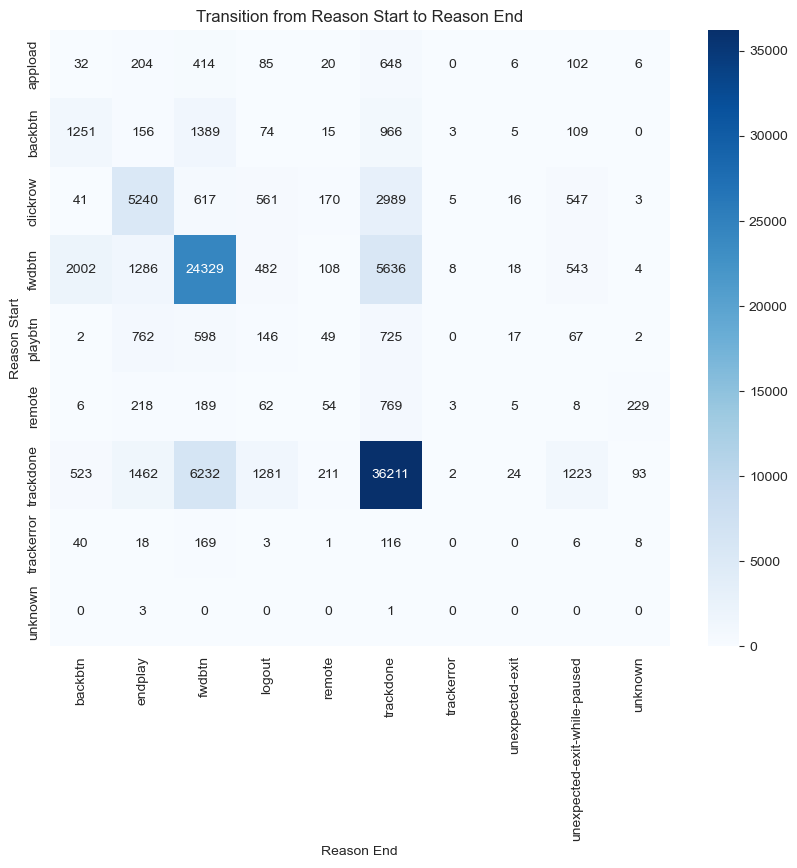

In [26]:
transition_crosstab = pd.crosstab(df['Start Reason'], df['End Reason'])

plt.figure(figsize=(10,8))
sns.heatmap(transition_crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Transition from Reason Start to Reason End')
plt.xlabel('Reason End')
plt.ylabel('Reason Start')
plt.show()

## Summary and Insights

### How accurate is my Spotify wrapped, and what can I expect for my 2024?

Spotify Wrapped data aligns closely but not perfectly with the analyzed dataset, likely due to differences in tracking periods and algorithms. There have been no official statements from Spotify but an article suggests<sup>[2]</sup> that the date range for 2024 could be different, compared to what has been reported over the years.

In comparing my wrapped data and the Spotify data however, I can determine it is close enough for me to at least estimate a few songs that might appear on my Spotify wrapped for the 2024 year. The top songs that are likely to appear on my 2024 wrapped are:
- Aura by Avoure
- Umoya by Karyendasoul
- Cooling The Plasma by GuyRo
- Wish We Could by Nico de Andrea
- Nocturne by Worakls

In [27]:
def get_data_for_year(df, year):
    return df[df['Year'] == year]

# Load and clean the wrapped data
wrapped_df = pd.read_json('./wrapped_data/Wrapped_Data.json')
wrapped_df.columns = ['Song Name', 'Artist', 'Year', 'Position']

all_years_data = []

# Loop through each year (2020–2023, as no data wrapped for 2019 and 2024)
for year in range(2020, 2024):
    df_year_wrapped = get_data_for_year(wrapped_df, year).reset_index(drop=True)

    # Get the top 5 songs from the dataset for the current year
    df_year_data = get_data_for_year(df, year).reset_index(drop=True)
    top_songs_year = df_year_data.groupby(['Song Name', 'Artist', 'Year'])['Minutes Played'] \
                                 .sum().sort_values(ascending=False).head(5).reset_index()
    top_songs_year.drop('Minutes Played', axis=1, inplace=True)

    # Merge the Wrapped data with the dataset data by position
    df_merged = df_year_wrapped.merge(top_songs_year, left_index=True, right_index=True)
    df_merged['Year'] = year
    df_merged.columns = ['Wrapped Song Name', 'Wrapped Artist', 'Wrapped Year', 'Position',
                         'Dataset Song Name', 'Dataset Artist', 'Dataset Year', 'Year']

    all_years_data.append(df_merged)

# Concatenate results for all years into a single DataFrame
final_df = pd.concat(all_years_data, ignore_index=True)

final_df.set_index(['Year', 'Position'], inplace=True)
final_df.drop(['Wrapped Year', 'Dataset Year'], axis=1, inplace=True)
final_df


Wrapped Song Name  \
Year Position                         
2020 1             Where Is My Mind   
     2                  Morning Sex   
     3                  Eine Minute   
     4                 Nightcrawler   
     5                      New Sky   
2021 1         Hold Me To The Light   
     2                Hide and Seek   
     3                        Caves   
     4                     La thune   
     5         Become the Warm Jets   
2022 1                           #3   
     2                  letzer song   
     3               Buzzcut Season   
     4           On Malencholy Hill   
     5         Drink Before the War   
2023 1                Hearts A Mess   
     2                   Rayon vert   
     3                         Woza   
     4             In This Darkness   
     5                Consideration   

                                           Wrapped Artist  \
Year Position                                               
2020 1                                      Maxence Cyrin   
     2                                     Ralph Castelli   
     3                                      Fynn Kliemann   
     4                                        Nosaj Thing   
     5                                       RÜFÜS DU SOL   
2021 1                                 KAS:ST, Be No Rain   
     2                                        Imogen Heap   
     3                                               Haux   
     4                                             Angèle   
     5                                       Current Joys   
2022 1                                         Aphex Twin   
     2                                                CRO   
     3                                              Lorde   
     4                                           Gorillaz   
     5                                    Sinéad O'Connor   
2023 1                                              Gotye   
     2                               Mylène Farmer, AaRON   
     3         Mr JazziQ, Kabza De Small, Lady Du, Boohle   
     4                                       Clara La San   
     5                                       Rihanna, SZA   

                                   Dataset Song Name    Dataset Artist  
Year Position                                                           
2020 1         No Time - RÜFÜS DU SOL Extended Remix         Lastlings  
     2                                       New Sky      RÜFÜS DU SOL  
     3                            Waste - RY X Remix              Rhye  
     4                              Where Is My Mind     Maxence Cyrin  
     5                                   Particle G1       Hannah Peel  
2021 1                          Hold Me To The Light            KAS:ST  
     2                                 Hide and Seek       Imogen Heap  
     3                          Become the Warm Jets      Current Joys  
     4                                         Caves              Haux  
     5         No Time - RÜFÜS DU SOL Extended Remix         Lastlings  
2022 1                                            #3        Aphex Twin  
     2                                  letzter song               CRO  
     3                                      Pyramids       Frank Ocean  
     4                          Drink Before the War   Sinéad O'Connor  
     5                                Buzzcut Season             Lorde  
2023 1                                 Hearts A Mess             Gotye  
     2                                          Woza         Mr JazziQ  
     3                                    Rayon vert     Mylène Farmer  
     4                                       Redbone  Childish Gambino  
     5                                       Massive             Drake

### What kind of patterns exist in my listening habits? 

In reviewing my listening habits, a few patterns stand out. I use shuffle mode for the majority of my listening (56.52%) and skip songs frequently. My skip rate has been increasing steadily over the years, reaching a peak in 2024, which also saw a significant drop in overall listening time. Most of my songs start and end due to skipping; I often start a song by skipping the previous one, and many tracks end the same way. Since skip tracking began in 2022, Germany, my current residence, has the highest skip count, followed by Italy, where I frequently travel, and Namibia, where I’ve spent extended periods.

My listening activity has generally declined each year since 2020, especially in 2024. From 2019 to 2021, my listening was high, partly because I used to play music while falling asleep, letting it run through the night until I woke up. During those years, I lived in Namibia, attended school, and had fewer responsibilities. Since moving to Germany in late 2021, my average monthly listening time has been decreasing, with 2024 marking the sharpest drop. This aligns with increased commitments: balancing a student job, studying, a relationship, and various projects all at once.

Looking at my typical weekly listening pattern from 2019 to 2024, I listen to music more frequently in the early mornings, with activity tapering off during the day. This trend shows a steady reduction in listening over time, with certain hours of the day having no listening data at all in recent years. My listening habits are also consistent between weekends and weekdays with a weekday average of 2.04 min and a weekend average of 2.11 min per song.

In terms of song start and end reasons, most songs begin and end because a track finishes (either the track itself or the one before it). I also frequently have “skip-skip,” “trackdone-skip,” and “clickrow-endplay” combinations. Given my heavy use of shuffle mode, the high skip count makes sense—I’m often searching for a particular song or mood without specifically knowing what to look for.

### Are there any seasonal trends or significant changes in my listening behavior?

There does not seem to be any seasonality in the data. Instead a lot of my music habits tend to be impacted by or based on events and situations that happen in my life. Notable spikes include 2020 overall during the COVID-19 pandemic and lockdown. Outside of this, other spike (relative to the monthly data of a year) include May 2022 and December 2022, where I experienced the death of someone close to me, and huge trip back to Namibia respectively.

I listen to more music when there is a major life event happening for me, such as a death, or a move or a trip. As these do not happen at regular times, they do not offer any pattern to analyze. The only significant and observable pattern is the overall decline of music quantity listened to over the years, particularly for 2024. Another factor contributing to this decline is that I have been more prone to listening to music from other sources such as Youtube, as I am leaning more towards longer listening sets by specific DJs, which is currently not possible with Spotify.

## Conclusion

In conclusion, analyzing my Spotify data has provided valuable insights into my listening habits over the years. I’ve observed patterns in when and how I listen, with significant shifts influenced by life changes, responsibilities, and personal routines. The data reveals a consistent preference for shuffle mode, a high skip rate, and a notable decline in listening time, especially in 2024. Understanding these trends gives me a clearer picture of how music fits into my life and how my habits have evolved. Overall, it’s a fascinating reflection of my lifestyle and changing priorities over time.

---

## References and Resources

1: Understanding my data - Spotify. (n.d.). Spotify. https://support.spotify.com/de-en/article/understanding-my-data/

2: Murray, C. (2024, November 4). Spotify wrapped will track data past Oct. 31—What we know about this year’s iteration. Forbes. https://www.forbes.com/sites/conormurray/2024/10/31/spotify-wrapped-will-track-data-past-oct-31-what-we-know-about-this-years-iteration/

3: ChatGPT for assistance in analysis and writing.